In [1]:
import pandas as pd
import numpy as np
from vowpalwabbit import pyvw
import matplotlib.pyplot as plt
import math
import slates

In [98]:
actions = [[0,1,2,3,4,5,6,7,8],[0,1,2,3,4,5,6]]
slate_action_sets = [["x="+str(i) for i in actions[0]],["y="+str(i) for i in actions[1]]]
cb_action_set = slates.combine(actions, ["x", "y"])
print(len(cb_action_set))

slate_args = "--ccb_explore_adf --cb_type ips --power_t 0 -l 0.005 --slate --quiet --epsilon 0.2 --interactions :: UAS"
cb_args = "--cb_explore_adf --cb_type ips --power_t 0 -l 0.005 --quiet --epsilon 0.2 --interactions :: UAA "

63


In [99]:
def cost_func_slates(prediction):
    if prediction[0][0][0] == 6 and prediction[1][0][0] == 4:
        return -1
    else:
        return 1
    
def cost_func_cb(chosen_action):
    if chosen_action == "x=6 y=4":
        return -1
    else:
        return 1

In [100]:
model = pyvw.vw(slate_args)
slates_outcomes = []
for _ in range(10000):
    shared_context = "constant"
    examples = slates.create_slates_example(model, shared_context, slate_action_sets)
    pred = slates.slate_pred_conv(model.predict(examples, prediction_type=pyvw.pylibvw.vw.pDECISION_SCORES))
    model.finish_example(examples)

    # Choose the slot to samlpe
    chosen_slot = np.random.choice(len(pred))
    slot_to_sample = pred[chosen_slot]
    # Sample an index from this slot
    index = slates.sample_index(slot_to_sample)
    # Swap sampled action if it was not the 0th item.
    if index != 0:
        slot_to_sample[0], slot_to_sample[index] = slot_to_sample[index], slot_to_sample[0]
    # Assign the potentially modified slot back into the prediction
    pred[chosen_slot] = slot_to_sample
    
    cost = cost_func_slates(pred)
    x_outcome = (pred[0][0][0], cost, pred[0][0][1])
    y_outcome = (pred[0][0][0], cost, pred[1][0][1])
    if(pred[0][0][1] > 0.5 and pred[1][0][1] > 0.5):
        slates_outcomes.append((x_outcome, y_outcome))

    examples = slates.create_slates_example(model, shared_context, slate_action_sets,  [x_outcome,y_outcome])
    model.learn(examples)
    model.finish_example(examples)

In [101]:
cb_model = pyvw.vw(cb_args)
# --interactions UUU AAA UUA AAU UUUA UUUAA UUUAAA"
                   
cb_outcomes = []
for _ in range(10000):
    shared_context = "constant"
    examples = slates.create_cb_example(cb_model, shared_context, cb_action_set)   
    pred = cb_model.predict(examples, prediction_type=pyvw.pylibvw.vw.pACTION_SCORES)
    cb_model.finish_example(examples)

    # Sample
    chosen_action_index = np.random.choice(len(pred), p=slates.normalize(pred))
    cost = cost_func_cb(cb_action_set[chosen_action_index])
    chosen_pred = pred[chosen_action_index]
    
    outcome = (chosen_action_index, cost, chosen_pred)
    if(chosen_pred > 0.5):
        cb_outcomes.append(outcome)
    examples = slates.create_cb_example(cb_model, shared_context, cb_action_set, outcome=outcome)
    cb_model.learn(examples)
    cb_model.finish_example(examples)

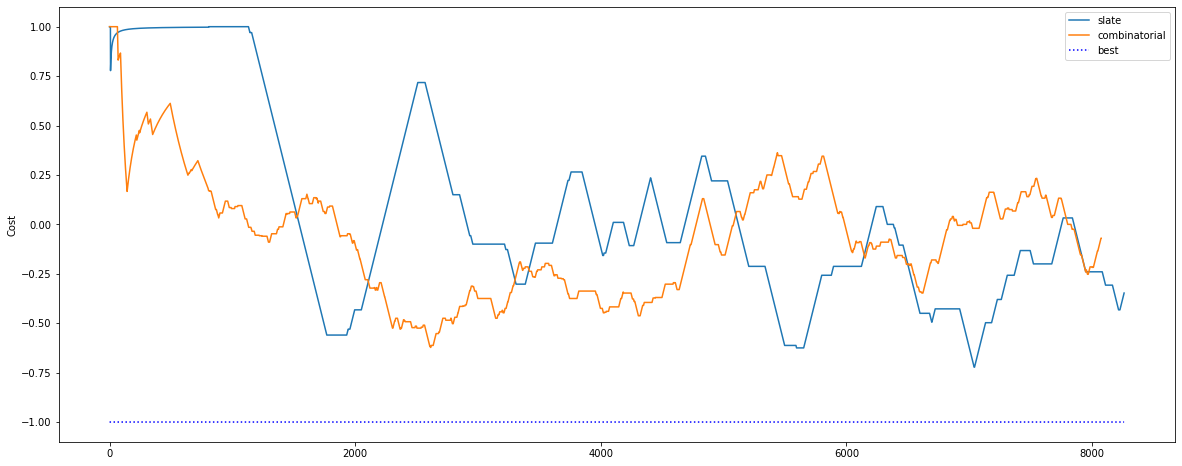

In [103]:
plt.figure(figsize=(20, 8))
number_of_samples = max(len(cb_outcomes), len(slates_outcomes))
plt.plot(pd.Series([cost for ((idx,cost,prob),(_,_,_)) in slates_outcomes]).rolling(800, min_periods=0).mean(), label="slate")
plt.plot(pd.Series([cost for (idx,cost,prob) in cb_outcomes]).rolling(800, min_periods=0).mean(), label="combinatorial")

plt.ylabel("Cost")
# Plot optimal policy by sampling optimal policy number_of_samples times
optimal_policy_results = [-1 for i in range(number_of_samples)]
plt.plot(pd.Series(optimal_policy_results).rolling(5, min_periods=0).mean(), color='b', linestyle=':', label="best")

plt.legend(loc="upper right")
plt.show()